In [53]:
# %%
import pandas as pd, json, re, os, natsort
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# print Source Function / Function / Call Stack column without truncation
pd.set_option('display.max_colwidth', None)
# display all columns
pd.set_option('display.max_columns', None)


plt.rc('axes', labelsize=63)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=60)    # fontsize of the tick labels
plt.rc('ytick', labelsize=60)    # fontsize of the tick labels
plt.rc('legend', fontsize=50)    # legend fontsize
# # increase size of axis label size
plt.rcParams['axes.labelsize'] = 65
# increase title size
plt.rcParams['axes.titlesize'] = 65
# increase space between axis label and axis
plt.rcParams['axes.labelpad'] = 50
# increase space between title and plot
plt.rcParams['axes.titlepad'] = 50
plt.rcParams['font.size'] = 50

# %%
mapping_file = '/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/mapping_funcs.json'
uarch_dir ='/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_vary_dataloaders_csv'

In [54]:
# load a json file
with open(mapping_file) as f:
    data = json.load(f)

cpp_funcs = set()

for py_func in data['op_to_func']:
    # if py_func == 'RandomResizedCrop' or py_func == 'convertRGB':
    for cpp_func in data['op_to_func'][py_func]:
        cpp_funcs.add(cpp_func.split('|')[0])
interested_functions = list(cpp_funcs)

# previous interested_functions =

# ["__memmove_avx_unaligned_erms",\
# "_int_free",\
# "ImagingResampleHorizontal_8bpc",\
# "ImagingResampleVertical_8bpc",\
# "ImagingFlipLeftRight",\
# "ImagingPackRGB",\
# "munmap",\
# "copy_kernel",\
# "div_true_kernel",\
# "direct_copy_kernel",\
# "add_kernel",\
# "decompress_onepass",\
# "jpeg_idct_islow",\
# "jpeg_idct_16x16",\
# "ycc_rgb_convert",\
# "decode_mcu",\
# "ImagingUnpackRGB",\
# "__memset_avx2_unaligned_erms",\
# "__libc_calloc",\
#         ]
uarch_files = []
# loop through uarch_dir and find csv files
for file in os.listdir(uarch_dir):
    if not file.endswith(".csv"):
        print("Files other than csv exist ", uarch_dir)
        exit(1)
    uarch_files.append(file)

# natsort uarch_files
uarch_files = natsort.natsorted(uarch_files)
print(uarch_files)

['b1024_gpu4_dataloader8.csv', 'b1024_gpu4_dataloader12.csv', 'b1024_gpu4_dataloader16.csv', 'b1024_gpu4_dataloader20.csv', 'b1024_gpu4_dataloader24.csv', 'b1024_gpu4_dataloader28.csv']


In [65]:
def display_comparison(config1,config2):
    combined_df = pd.DataFrame()
    # loop through uarch_dir and find csv files
    for uarch_file_ in uarch_files:
        if not file.endswith(".csv"):
            print("Files other than csv exist ", uarch_dir)
            exit(1)
        print(uarch_file_)
        if not(config1 in uarch_file_ or config2 in uarch_file_):
            continue


        uarch_file = os.path.join(uarch_dir, uarch_file_)

        # %%
        #  read csv separated by tab
        df = pd.read_csv(uarch_file, sep='\t')

        # %%
        # remove trailing "s" in 'CPU Time' column and cast the column to float
        df['CPU Time'] = df['CPU Time'].str.rstrip('s').astype(float)
        # create a new column called "CPU Time %" from "CPU Time" column
        df['CPU Time %'] = df['CPU Time'] / df['CPU Time'].sum() * 100

        # %%
        # sort by column 'CPU Time' and reset index
        df = df.sort_values(by=['CPU Time'], ascending=False).reset_index(drop=True)

        # %%
        #  find index of interested functions in the dataframe in "Source Function / Function / Call Stack" column
        indices = {}
        empty_indices = []
        print('uarch_file: ', uarch_file)
        for func in interested_functions:
            # escape special characters
            func_ = re.escape(func)
            indices_for_func = df[df["Source Function / Function / Call Stack"].str.contains(func_)].index.values
            # if empty, add to empty_indices
            if len(indices_for_func) == 0:
                empty_indices.append(func)
            else:
                indices[func] = indices_for_func
        # print("C/C++ functions not found in dataframe:")
        # print(empty_indices)
        # print("C/C++ functions (indices) found in dataframe:")    
        # for func in indices:
        #     print("Index:",indices[func],"Function: ", func)
        # print('\n\n')

        # %%
        # find above functions in the dataframe and map the function name to the one in interested_functions

        # for function in interested_functions:
        #     df.loc[df['Source Function / Function / Call Stack'].str.contains(function), 'Source Function / Function / Call Stack'] = function


        # %%
        # combine all the interested functions' row into a dataframe
        df2 = pd.DataFrame()
        for func in indices:
            df2 = pd.concat([df2,df.iloc[indices[func]]])

        # %%
        # sort by 'CPU Time' column and reset index
        df2 = df2.sort_values(by=['CPU Time %'], ascending=False).reset_index(drop=True)
        # rename 'CPU Time' column to 'CPU Time (s)'
        df2 = df2.rename(columns={"CPU Time": "CPU Time (s)"})
        remove_cols = [
            "Source File",
            "Start Address",
            "Module",
            "Average CPU Frequency",
            # "Clockticks",
            "Instructions Retired",
            "CPI Rate",
            "Function (Full)"
        ] 
        # remove columns
        df2 = df2.drop(columns=remove_cols)

        # add column 'uarch_file' to df2 with value uarch_file
        tmp = uarch_file_.split('.csv')[0]
        tmp = tmp.split('_')
        batch_size = tmp[0].split('b')[1]
        gpus = tmp[1].split('g')[1]
        dataloaders = tmp[2].split('dataloader')[1]
        print(dataloaders)
        df2['dataloaders'] = int(dataloaders)

        percentage_symbol_cols = [
            'Retiring',
            'Front-End Bound', 
            'Bad Speculation', 
            'L1 Bound', 
            'L2 Bound',
            'L3 Bound', 
            'Memory Bandwidth', 
            'Local DRAM', 
            'Remote DRAM',
            'Remote Cache', 
            'Store Bound', 
            'Core Bound',
            ]
        
        # remove the % symbol and cast the column to float
        for col in percentage_symbol_cols:
            df2[col] = df2[col].str.rstrip('%').astype(float)
        
        # cast 'Clockticks' column to float, but remove ',' from it first
        df2['Clockticks'] = df2['Clockticks'].str.replace(',', '').astype(float)
        
        


        # %%
        # print sum of 'CPU Time %' contributed
        # print config i.e. batch_size and gpus
        print(f"sum of 'CPU Time %' contributed by config {(batch_size,gpus)}: {df2['CPU Time %'].sum():.2f}%")
        
        # rename 'Source Function / Function / Call Stack' column to 'Functions'
        df2 = df2.rename(columns={"Source Function / Function / Call Stack": "Functions"})
        # %%
        # set index to 'Source Function / Function / Call Stack' column
        df2 = df2.set_index('Functions')

        def flatten(S):
            if len(S)==1:
                return [S[0]]
            if isinstance(S[0], list):
                return flatten(S[0]) + flatten(S[1:])
            return S[:1] + flatten(S[1:])

        combined_df = pd.concat([combined_df, df2])
    # %%
    # reset index
    combined_df = combined_df.reset_index()

    func_rename = {
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(float)#1}, at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>)#2}>>': 'AVX2::direct_copy_kernel(float)',
        'at::native::AVX2::vectorized_loop<at::native::(anonymous namespace)::div_true_kernel(at::TensorIteratorBase&)::{lambda()#1}::operator()(void) const::{lambda()#2}::operator()(void) const::{lambda(floatfloat)#1}&, at::native::(anonymous namespace)::div_true_kernel(at::TensorIteratorBase&)::{lambda()#1}::operator()(void) const::{lambda()#2}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>at::vec::AVX2::Vectorized<float>)#2}&>.isra.0' :'AVX2::div_true_kernel(float)',
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(unsigned char)#1}, at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<unsigned char>)#2}>>' : 'AVX2::direct_copy_kernel(unsigned char)',
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::TensorIteratorBase::loop_2d_from_1d<at::native::AVX2::copy_kernel(at::TensorIterator&, bool)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(char**long const*, long)#1}>(, signed char, at::native::AVX2::copy_kernel(at::TensorIterator&, bool)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(char**long const*, long)#1} const&)::{lambda(char**long const*, long, long)#1}>' : 'AVX2::copy_kernel(char**long const*, long, long)',
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::(anonymous namespace)::add_kernel(at::TensorIteratorBase&, c10::Scalar const&)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(floatfloat)#1}, at::native::(anonymous namespace)::add_kernel(at::TensorIteratorBase&, c10::Scalar const&)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>at::vec::AVX2::Vectorized<float>)#2}>>' : 'add_kernel(float)',
    }

    # replace function names in 'Source Function / Function / Call Stack' column

    combined_df['Functions'] = combined_df['Functions'].replace(func_rename)  

    # Remove functions taking less than 1% of CPU total time
    functions_to_remove = combined_df[combined_df.groupby('Functions')['CPU Time %'].transform('min') < 1]['Functions']
    
    print("Below are functions taking less than 1% of CPU total time in at least one configuration:")
    print(functions_to_remove.unique())

    # print high level functions these functions belong to
    print("Below are high level functions these functions belong to:")
    for func in functions_to_remove.unique():
        for py_func in data['op_to_func']:
            for cpp_func in data['op_to_func'][py_func]:
                if cpp_func.split('|')[0] == func:
                    print('\t' + py_func)
                    break

    # remove functions in functions_to_remove from combined_df
    combined_df = combined_df[~combined_df['Functions'].isin(functions_to_remove)]

    return combined_df


In [66]:
dataloaders_config1 = 28
dataloaders_config2 = 24
config1 = 'dataloader' + str(dataloaders_config1)
config2  = 'dataloader' + str(dataloaders_config2)

In [67]:
df = display_comparison(config1,config2)

b1024_gpu4_dataloader8.csv
b1024_gpu4_dataloader12.csv
b1024_gpu4_dataloader16.csv
b1024_gpu4_dataloader20.csv
b1024_gpu4_dataloader24.csv
uarch_file:  /mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_vary_dataloaders_csv/b1024_gpu4_dataloader24.csv
24
sum of 'CPU Time %' contributed by config ('1024', 'pu4'): 74.53%
b1024_gpu4_dataloader28.csv
uarch_file:  /mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_vary_dataloaders_csv/b1024_gpu4_dataloader28.csv
28
sum of 'CPU Time %' contributed by config ('1024', 'pu4'): 74.19%
Below are functions taking less than 1% of CPU total time in at least one configuration:
['AVX2::copy_kernel(char**long const*, long, long)' 'ImagingPackRGB'
 '__memset_avx2_unaligned_erms' 'add_kernel(float)' 'ImagingFlipLeftRight'
 '_int_free' '__libc_calloc']
Below are high level functions these functions belong to:
	ToTensor
	con

In [68]:
df.head(len(df))

,Functions,CPU Time (s),Clockticks,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound,CPU Time %,dataloaders
0,decode_mcu,2340.983,7.709760e+12,48.9,14.5,39.8,21.8,1.0,0.5,10.3,0.0,0.0,0.0,0.3,0.0,17.866946,24
1,jpeg_idct_islow,2059.013,6.815168e+12,82.4,10.6,3.6,4.5,0.2,0.1,9.3,0.0,0.1,0.0,1.0,3.1,15.714883,24
2,ImagingResampleHorizontal_8bpc,1059.906,3.508864e+12,88.3,7.7,2.1,7.8,0.3,0.2,14.1,0.1,0.0,0.0,0.0,1.6,8.089458,24
3,ycc_rgb_convert,869.651,2.804560e+12,88.9,10.3,0.0,4.4,0.3,0.3,11.2,0.0,0.0,0.0,0.5,0.9,6.637386,24
4,ImagingResampleVertical_8bpc,729.286,2.445408e+12,87.8,6.9,1.1,10.4,0.2,0.5,9.1,0.2,0.0,0.0,0.6,3.4,5.566086,24
5,jpeg_fill_bit_buffer,542.841,1.782272e+12,44.0,21.8,40.8,14.2,0.1,0.0,9.4,0.0,0.2,0.0,0.0,0.0,4.143093,24
6,__memmove_avx_unaligned_erms,440.451,1.497120e+12,6.2,3.9,2.2,24.2,8.5,10.1,48.3,100.0,2.0,0.0,82.9,5.5,3.361628,24
7,jpeg_idct_16x16,381.536,1.219360e+12,89.0,11.2,0.0,4.2,0.1,0.1,9.6,0.0,0.0,0.0,2.3,0.0,2.911975,24
8,AVX2::direct_copy_kernel(float),262.325,8.952160e+11,6.7,4.2,0.0,18.2,9.1,16.7,73.2,100.0,100.0,0.0,82.9,5.6,2.002128,24
9,ImagingUnpackRGB,224.310,7.540800e+11,91.5,8.7,0.0,8.0,0.2,0.0,10.7,0.0,0.0,0.0,5.7,3.9,1.711988,24


In [69]:
# get dataframe for batch_size = 256 and gpus = 1
df1 = df[df['dataloaders'] == dataloaders_config1].copy().reset_index(drop=True)
# get dataframe for batch_size = 1024 and gpus = 4
df2 = df[df['dataloaders'] == dataloaders_config2].copy().reset_index(drop=True)

# drop 'batch_size' and 'gpus' columns
df1 = df1.drop(columns=['dataloaders'])
df2 = df2.drop(columns=['dataloaders'])
# drop CPU Time % column
df1 = df1.drop(columns=['CPU Time %'])
df2 = df2.drop(columns=['CPU Time %'])


In [70]:
df1.head(len(df1))


,Functions,CPU Time (s),Clockticks,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,2529.858,8.396080e+12,48.9,15.9,38.3,21.0,1.2,0.6,10.0,0.0,0.0,0.0,0.4,0.0
1,jpeg_idct_islow,2285.968,7.541504e+12,80.5,11.7,4.0,5.0,0.1,0.1,9.3,0.0,0.0,0.0,1.1,3.3
2,ImagingResampleHorizontal_8bpc,1092.406,3.654464e+12,94.7,10.0,0.0,8.9,0.5,0.2,14.9,0.0,0.0,0.0,0.0,0.0
3,ycc_rgb_convert,959.796,3.177072e+12,85.6,11.8,0.0,5.0,0.2,0.3,10.7,0.0,0.0,0.0,0.4,2.8
4,ImagingResampleVertical_8bpc,728.621,2.479424e+12,95.8,8.7,0.0,11.8,0.5,0.5,10.6,0.9,0.0,0.0,0.7,0.0
5,jpeg_fill_bit_buffer,598.461,1.965632e+12,45.8,22.5,37.8,13.4,0.2,0.1,9.3,0.2,0.0,0.0,0.0,0.0
6,__memmove_avx_unaligned_erms,456.921,1.545584e+12,6.8,5.5,1.2,23.3,8.1,9.2,49.0,100.0,1.9,0.0,84.4,7.8
7,jpeg_idct_16x16,401.416,1.369104e+12,89.9,13.7,0.0,5.2,0.1,0.0,9.6,0.0,0.0,0.0,2.8,0.0
8,AVX2::direct_copy_kernel(float),274.255,8.965760e+11,7.6,5.0,0.0,14.1,15.2,14.8,77.3,100.0,100.0,0.0,87.8,3.8
9,ImagingUnpackRGB,249.785,8.257120e+11,89.3,7.7,5.5,8.6,0.3,1.0,10.5,0.0,0.0,0.0,6.5,0.0


In [71]:
df2.head(len(df2))

,Functions,CPU Time (s),Clockticks,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,2340.983,7.709760e+12,48.9,14.5,39.8,21.8,1.0,0.5,10.3,0.0,0.0,0.0,0.3,0.0
1,jpeg_idct_islow,2059.013,6.815168e+12,82.4,10.6,3.6,4.5,0.2,0.1,9.3,0.0,0.1,0.0,1.0,3.1
2,ImagingResampleHorizontal_8bpc,1059.906,3.508864e+12,88.3,7.7,2.1,7.8,0.3,0.2,14.1,0.1,0.0,0.0,0.0,1.6
3,ycc_rgb_convert,869.651,2.804560e+12,88.9,10.3,0.0,4.4,0.3,0.3,11.2,0.0,0.0,0.0,0.5,0.9
4,ImagingResampleVertical_8bpc,729.286,2.445408e+12,87.8,6.9,1.1,10.4,0.2,0.5,9.1,0.2,0.0,0.0,0.6,3.4
5,jpeg_fill_bit_buffer,542.841,1.782272e+12,44.0,21.8,40.8,14.2,0.1,0.0,9.4,0.0,0.2,0.0,0.0,0.0
6,__memmove_avx_unaligned_erms,440.451,1.497120e+12,6.2,3.9,2.2,24.2,8.5,10.1,48.3,100.0,2.0,0.0,82.9,5.5
7,jpeg_idct_16x16,381.536,1.219360e+12,89.0,11.2,0.0,4.2,0.1,0.1,9.6,0.0,0.0,0.0,2.3,0.0
8,AVX2::direct_copy_kernel(float),262.325,8.952160e+11,6.7,4.2,0.0,18.2,9.1,16.7,73.2,100.0,100.0,0.0,82.9,5.6
9,ImagingUnpackRGB,224.310,7.540800e+11,91.5,8.7,0.0,8.0,0.2,0.0,10.7,0.0,0.0,0.0,5.7,3.9


In [72]:
# get type of Clokcticks column
print(type(df1['Clockticks'][0]))

<class 'numpy.float64'>


In [73]:
# multiply each column in df1 and df2 by CPU Time % and divide by 100 except for column 'Functions' and CPU Time %
df1[df1.columns[1:]] = df1[df1.columns[1:]].mul(df1['Clockticks'], axis=0)
df2[df2.columns[1:]] = df2[df2.columns[1:]].mul(df2['Clockticks'], axis=0)


In [74]:
# drop CPU Time (s) column
df1 = df1.drop(columns=['CPU Time (s)','Clockticks'])
df2 = df2.drop(columns=['CPU Time (s)','Clockticks'])

In [75]:
df1.head(len(df1))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,4.105683e+14,1.334977e+14,3.215699e+14,1.763177e+14,1.007530e+13,5.037648e+12,8.396080e+13,0.000000e+00,0.000000e+00,0.0,3.358432e+12,0.000000e+00
1,jpeg_idct_islow,6.070911e+14,8.823560e+13,3.016602e+13,3.770752e+13,7.541504e+11,7.541504e+11,7.013599e+13,0.000000e+00,0.000000e+00,0.0,8.295654e+12,2.488696e+13
2,ImagingResampleHorizontal_8bpc,3.460777e+14,3.654464e+13,0.000000e+00,3.252473e+13,1.827232e+12,7.308928e+11,5.445151e+13,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
3,ycc_rgb_convert,2.719574e+14,3.748945e+13,0.000000e+00,1.588536e+13,6.354144e+11,9.531216e+11,3.399467e+13,0.000000e+00,0.000000e+00,0.0,1.270829e+12,8.895802e+12
4,ImagingResampleVertical_8bpc,2.375288e+14,2.157099e+13,0.000000e+00,2.925720e+13,1.239712e+12,1.239712e+12,2.628189e+13,2.231482e+12,0.000000e+00,0.0,1.735597e+12,0.000000e+00
5,jpeg_fill_bit_buffer,9.002595e+13,4.422672e+13,7.430089e+13,2.633947e+13,3.931264e+11,1.965632e+11,1.828038e+13,3.931264e+11,0.000000e+00,0.0,0.000000e+00,0.000000e+00
6,__memmove_avx_unaligned_erms,1.050997e+13,8.500712e+12,1.854701e+12,3.601211e+13,1.251923e+13,1.421937e+13,7.573362e+13,1.545584e+14,2.936610e+12,0.0,1.304473e+14,1.205556e+13
7,jpeg_idct_16x16,1.230824e+14,1.875672e+13,0.000000e+00,7.119341e+12,1.369104e+11,0.000000e+00,1.314340e+13,0.000000e+00,0.000000e+00,0.0,3.833491e+12,0.000000e+00
8,AVX2::direct_copy_kernel(float),6.813978e+12,4.482880e+12,0.000000e+00,1.264172e+13,1.362796e+13,1.326932e+13,6.930532e+13,8.965760e+13,8.965760e+13,0.0,7.871937e+13,3.406989e+12
9,ImagingUnpackRGB,7.373608e+13,6.357982e+12,4.541416e+12,7.101123e+12,2.477136e+11,8.257120e+11,8.669976e+12,0.000000e+00,0.000000e+00,0.0,5.367128e+12,0.000000e+00


In [76]:
df2.head(len(df2))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,3.770073e+14,1.117915e+14,3.068484e+14,1.680728e+14,7.709760e+12,3.854880e+12,7.941053e+13,0.000000e+00,0.000000e+00,0.0,2.312928e+12,0.000000e+00
1,jpeg_idct_islow,5.615698e+14,7.224078e+13,2.453460e+13,3.066826e+13,1.363034e+12,6.815168e+11,6.338106e+13,0.000000e+00,6.815168e+11,0.0,6.815168e+12,2.112702e+13
2,ImagingResampleHorizontal_8bpc,3.098327e+14,2.701825e+13,7.368614e+12,2.736914e+13,1.052659e+12,7.017728e+11,4.947498e+13,3.508864e+11,0.000000e+00,0.0,0.000000e+00,5.614182e+12
3,ycc_rgb_convert,2.493254e+14,2.888697e+13,0.000000e+00,1.234006e+13,8.413680e+11,8.413680e+11,3.141107e+13,0.000000e+00,0.000000e+00,0.0,1.402280e+12,2.524104e+12
4,ImagingResampleVertical_8bpc,2.147068e+14,1.687332e+13,2.689949e+12,2.543224e+13,4.890816e+11,1.222704e+12,2.225321e+13,4.890816e+11,0.000000e+00,0.0,1.467245e+12,8.314387e+12
5,jpeg_fill_bit_buffer,7.841997e+13,3.885353e+13,7.271670e+13,2.530826e+13,1.782272e+11,0.000000e+00,1.675336e+13,0.000000e+00,3.564544e+11,0.0,0.000000e+00,0.000000e+00
6,__memmove_avx_unaligned_erms,9.282144e+12,5.838768e+12,3.293664e+12,3.623030e+13,1.272552e+13,1.512091e+13,7.231090e+13,1.497120e+14,2.994240e+12,0.0,1.241112e+14,8.234160e+12
7,jpeg_idct_16x16,1.085230e+14,1.365683e+13,0.000000e+00,5.121312e+12,1.219360e+11,1.219360e+11,1.170586e+13,0.000000e+00,0.000000e+00,0.0,2.804528e+12,0.000000e+00
8,AVX2::direct_copy_kernel(float),5.997947e+12,3.759907e+12,0.000000e+00,1.629293e+13,8.146466e+12,1.495011e+13,6.552981e+13,8.952160e+13,8.952160e+13,0.0,7.421341e+13,5.013210e+12
9,ImagingUnpackRGB,6.899832e+13,6.560496e+12,0.000000e+00,6.032640e+12,1.508160e+11,0.000000e+00,8.068656e+12,0.000000e+00,0.000000e+00,0.0,4.298256e+12,2.940912e+12


In [77]:
# get functions that are not common in both dataframes
df_unique = df1[~df1['Functions'].isin(df2['Functions'])]

In [78]:
# check if empty
if len(df_unique) == 0:
    print("No unique functions in both dataframes")

No unique functions in both dataframes


In [79]:
# map each function in df1 based on CPU Time % to a integer
func_to_int = {}
for i, func in enumerate(df1['Functions']):
    func_to_int[func] = i

In [80]:
# subtract df1 from df2 across Functions column
df3 = df2.set_index('Functions').sub(df1.set_index('Functions'), fill_value=0).reset_index()

In [81]:
# sort index in df3 based on func_to_int
df3 = df3.set_index(df3['Functions'].map(func_to_int)).sort_index().reset_index(drop=True)

In [82]:
# round all the values in df3 to 2 decimal places
df3 = df3.round(2)

In [83]:
df3.head(len(df3))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,-3.356105e+13,-2.170615e+13,-1.472142e+13,-8.244912e+12,-2.365536e+12,-1.182768e+12,-4.550272e+12,0.000000e+00,0.000000e+00,0.0,-1.045504e+12,0.000000e+00
1,jpeg_idct_islow,-4.552123e+13,-1.599482e+13,-5.631411e+12,-7.039264e+12,6.088832e+11,-7.263360e+10,-6.754925e+12,0.000000e+00,6.815168e+11,0.0,-1.480486e+12,-3.759942e+12
2,ImagingResampleHorizontal_8bpc,-3.624505e+13,-9.526387e+12,7.368614e+12,-5.155590e+12,-7.745728e+11,-2.912000e+10,-4.976531e+12,3.508864e+11,0.000000e+00,0.0,0.000000e+00,5.614182e+12
3,ycc_rgb_convert,-2.263198e+13,-8.602482e+12,0.000000e+00,-3.545296e+12,2.059536e+11,-1.117536e+11,-2.583598e+12,0.000000e+00,0.000000e+00,0.0,1.314512e+11,-6.371698e+12
4,ImagingResampleVertical_8bpc,-2.282200e+13,-4.697674e+12,2.689949e+12,-3.824960e+12,-7.506304e+11,-1.700800e+10,-4.028682e+12,-1.742400e+12,0.000000e+00,0.0,-2.683520e+11,8.314387e+12
5,jpeg_fill_bit_buffer,-1.160598e+13,-5.373190e+12,-1.584192e+12,-1.031206e+12,-2.148992e+11,-1.965632e+11,-1.527021e+12,-3.931264e+11,3.564544e+11,0.0,0.000000e+00,0.000000e+00
6,__memmove_avx_unaligned_erms,-1.227827e+12,-2.661944e+12,1.438963e+12,2.181968e+11,2.062896e+11,9.015392e+11,-3.422720e+12,-4.846400e+12,5.763040e+10,0.0,-6.336042e+12,-3.821395e+12
7,jpeg_idct_16x16,-1.455941e+13,-5.099893e+12,0.000000e+00,-1.998029e+12,-1.497440e+10,1.219360e+11,-1.437542e+12,0.000000e+00,0.000000e+00,0.0,-1.028963e+12,0.000000e+00
8,AVX2::direct_copy_kernel(float),-8.160304e+11,-7.229728e+11,0.000000e+00,3.651210e+12,-5.481490e+12,1.680782e+12,-3.775514e+12,-1.360000e+11,-1.360000e+11,0.0,-4.505966e+12,1.606221e+12
9,ImagingUnpackRGB,-4.737762e+12,2.025136e+11,-4.541416e+12,-1.068483e+12,-9.689760e+10,-8.257120e+11,-6.013200e+11,0.000000e+00,0.000000e+00,0.0,-1.068872e+12,2.940912e+12


In [ ]:
# save df3 to csv
df3.to_csv(f'./{config2}_minus_{config1}_diff.csv', index=False)

In [84]:
# plot bar graph for df3 with functions on x axis and all other columns on y axis
df3.plot(x='Functions', kind='bar', figsize=(150, 30), fontsize=50, width=0.3)

#  add x axis label
plt.xlabel('Functions')
# add y axis label
plt.ylabel(f'Difference {config2} - {config1} (metric % * CPU time) ')
# add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=50)

In [ ]:
df3.head(len(df3))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,0.0,-1.4,1.5,0.8,-0.2,-0.1,0.3,0.0,0.0,0.0,-0.1,0.0
1,jpeg_idct_islow,1.9,-1.1,-0.4,-0.5,0.1,0.0,0.0,0.0,0.1,0.0,-0.1,-0.2
2,ImagingResampleHorizontal_8bpc,-6.4,-2.3,2.1,-1.1,-0.2,0.0,-0.8,0.1,0.0,0.0,0.0,1.6
3,ycc_rgb_convert,3.3,-1.5,0.0,-0.6,0.1,0.0,0.5,0.0,0.0,0.0,0.1,-1.9
4,ImagingResampleVertical_8bpc,-8.0,-1.8,1.1,-1.4,-0.3,0.0,-1.5,-0.7,0.0,0.0,-0.1,3.4
5,jpeg_fill_bit_buffer,-1.8,-0.7,3.0,0.8,-0.1,-0.1,0.1,-0.2,0.2,0.0,0.0,0.0
6,__memmove_avx_unaligned_erms,-0.6,-1.6,1.0,0.9,0.4,0.9,-0.7,0.0,0.1,0.0,-1.5,-2.3
7,jpeg_idct_16x16,-0.9,-2.5,0.0,-1.0,0.0,0.1,0.0,0.0,0.0,0.0,-0.5,0.0
8,AVX2::direct_copy_kernel(float),-0.9,-0.8,0.0,4.1,-6.1,1.9,-4.1,0.0,0.0,0.0,-4.9,1.8
9,ImagingUnpackRGB,2.2,1.0,-5.5,-0.6,-0.1,-1.0,0.2,0.0,0.0,0.0,-0.8,3.9


In [ ]:
# only keep float with two decimal places
df3 = df3.round(2)

In [ ]:
df3.head(len(df3))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,0.0,-1.4,1.5,0.8,-0.2,-0.1,0.3,0.0,0.0,0.0,-0.1,0.0
1,jpeg_idct_islow,1.9,-1.1,-0.4,-0.5,0.1,0.0,0.0,0.0,0.1,0.0,-0.1,-0.2
2,ImagingResampleHorizontal_8bpc,-6.4,-2.3,2.1,-1.1,-0.2,0.0,-0.8,0.1,0.0,0.0,0.0,1.6
3,ycc_rgb_convert,3.3,-1.5,0.0,-0.6,0.1,0.0,0.5,0.0,0.0,0.0,0.1,-1.9
4,ImagingResampleVertical_8bpc,-8.0,-1.8,1.1,-1.4,-0.3,0.0,-1.5,-0.7,0.0,0.0,-0.1,3.4
5,jpeg_fill_bit_buffer,-1.8,-0.7,3.0,0.8,-0.1,-0.1,0.1,-0.2,0.2,0.0,0.0,0.0
6,__memmove_avx_unaligned_erms,-0.6,-1.6,1.0,0.9,0.4,0.9,-0.7,0.0,0.1,0.0,-1.5,-2.3
7,jpeg_idct_16x16,-0.9,-2.5,0.0,-1.0,0.0,0.1,0.0,0.0,0.0,0.0,-0.5,0.0
8,AVX2::direct_copy_kernel(float),-0.9,-0.8,0.0,4.1,-6.1,1.9,-4.1,0.0,0.0,0.0,-4.9,1.8
9,ImagingUnpackRGB,2.2,1.0,-5.5,-0.6,-0.1,-1.0,0.2,0.0,0.0,0.0,-0.8,3.9


In [ ]:
# create a dataframe for rpevious cell
df4 = pd.DataFrame(columns=['Functions', 'Metric', 'Value'])
for i, row in df3.iterrows():
    for j, col in enumerate(df3.columns):
        if j == 0:
            continue
        if row[col] > 10:
            temp_df = pd.DataFrame({'Functions': row['Functions'], 'Metric': col, 'Value': row[col]}, index=[0])
            df4 = pd.concat([df4,temp_df], ignore_index=True)
print(df4.head(len(df4)))

Empty DataFrame
Columns: [Functions, Metric, Value]
Index: []


In [ ]:
# create a dataframe for rpevious cell
total = 0
df4 = pd.DataFrame(columns=['Functions', 'Metric', 'Value'])
for i, row in df3.iterrows():
    for j, col in enumerate(df3.columns):
        if j == 0:
            continue
        if row[col] > 0:
            total += row[col]
            temp_df = pd.DataFrame({'Functions': row['Functions'], 'Metric': col, 'Value': row[col]}, index=[0])
            df4 = pd.concat([df4,temp_df], ignore_index=True)
print(total)
# sort df4 by 'Value' column
df4 = df4.sort_values(by=['Value'], ascending=False).reset_index(drop=True)
# print(df4.head(len(df4)))

# loop through df4 and print each row
for i, row in df4.iterrows():
    print(f"{row['Functions']}\n\t{row['Metric']}\n\t\t{row['Value']}")

47.39999999999999
AVX2::direct_copy_kernel(float)
	L1 Bound
		4.1
ImagingUnpackRGB
	Core Bound
		3.9
decompress_onepass
	Bad Speculation
		3.8
ImagingResampleVertical_8bpc
	Core Bound
		3.4
ycc_rgb_convert
	Retiring
		3.3
jpeg_fill_bit_buffer
	Bad Speculation
		3.0
ImagingUnpackRGB
	Retiring
		2.2
ImagingResampleHorizontal_8bpc
	Bad Speculation
		2.1
AVX2::direct_copy_kernel(float)
	L3 Bound
		1.9
jpeg_idct_islow
	Retiring
		1.9
AVX2::direct_copy_kernel(float)
	Core Bound
		1.8
ImagingResampleHorizontal_8bpc
	Core Bound
		1.6
decode_mcu
	Bad Speculation
		1.5
ImagingResampleVertical_8bpc
	Bad Speculation
		1.1
ImagingUnpackRGB
	Front-End Bound
		1.0
__memmove_avx_unaligned_erms
	Bad Speculation
		1.0
AVX2::direct_copy_kernel(unsigned char)
	Bad Speculation
		0.9
AVX2::direct_copy_kernel(unsigned char)
	Memory Bandwidth
		0.9
__memmove_avx_unaligned_erms
	L1 Bound
		0.9
__memmove_avx_unaligned_erms
	L3 Bound
		0.9
AVX2::div_true_kernel(float)
	Core Bound
		0.8
jpeg_fill_bit_buffer
	L1 B

/tmp/ipykernel_120186/3090198866.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df4 = pd.concat([df4,temp_df], ignore_index=True)


In [ ]:
# create a dataframe for rpevious cell
total = 0
df4 = pd.DataFrame(columns=['Functions', 'Metric', 'Value'])
for i, row in df3.iterrows():
    for j, col in enumerate(df3.columns):
        if j == 0:
            continue
        total += row[col]

print(f"Total difference between {config2} and {config1} is {total:.2f}")

Total difference between dataloader24 and dataloader28 is -45.40


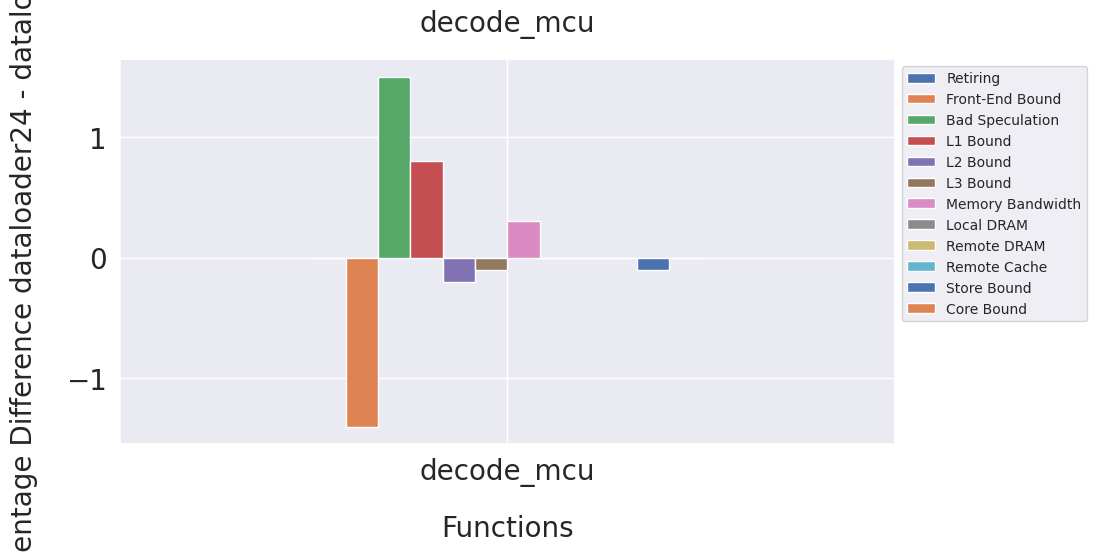

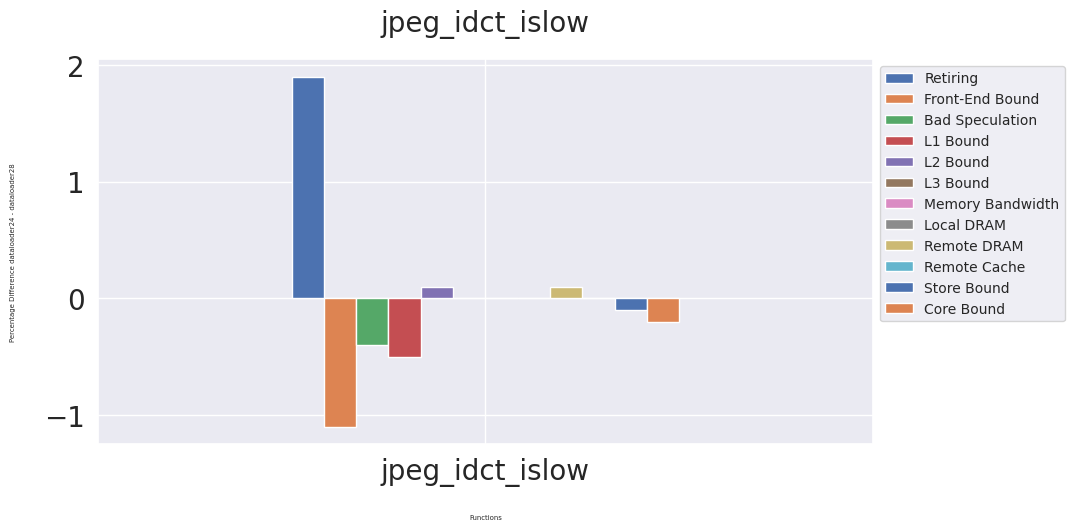

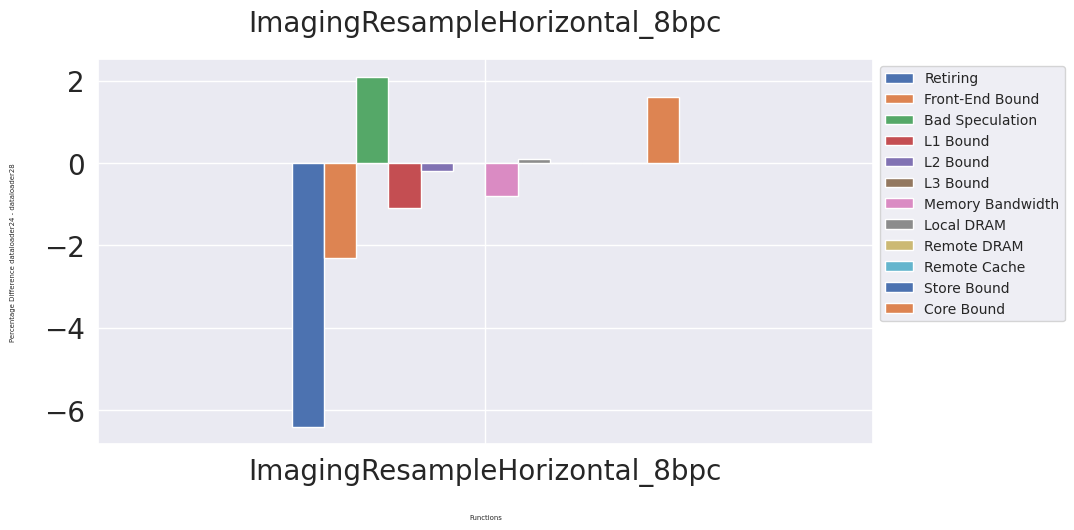

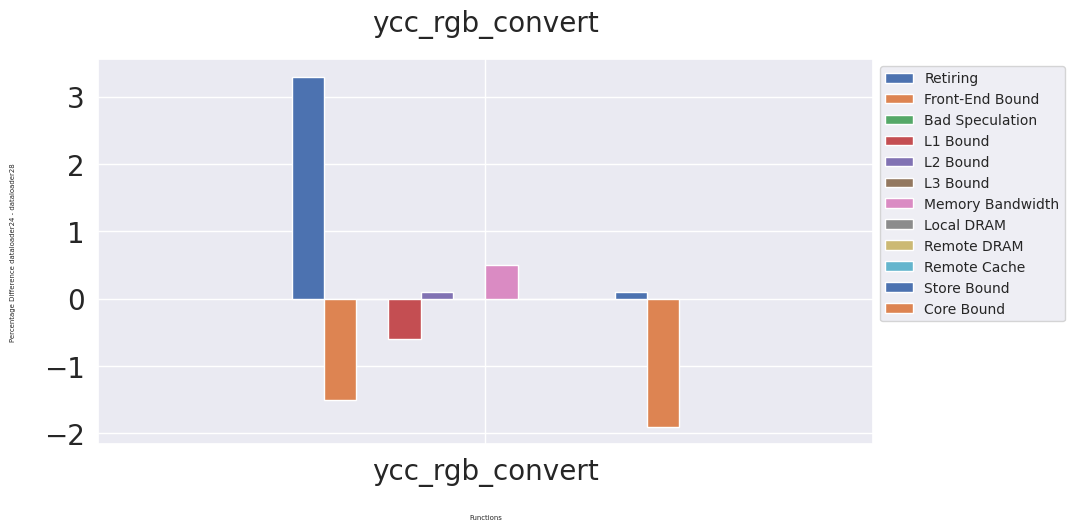

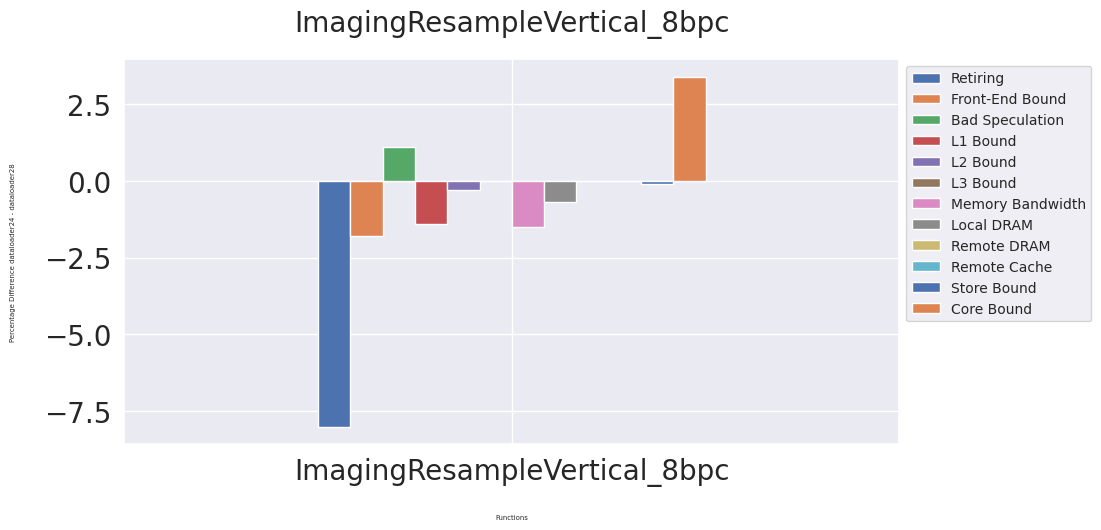

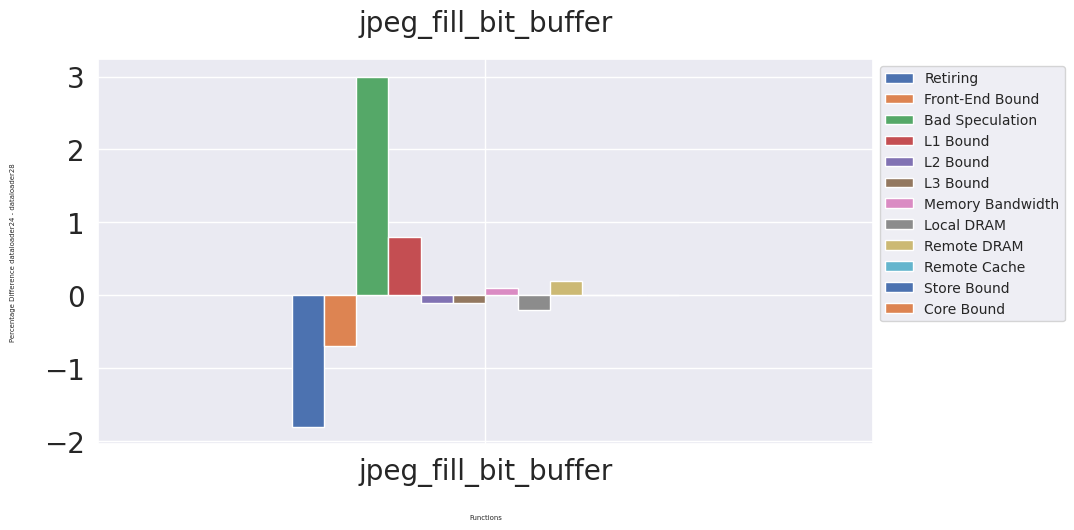

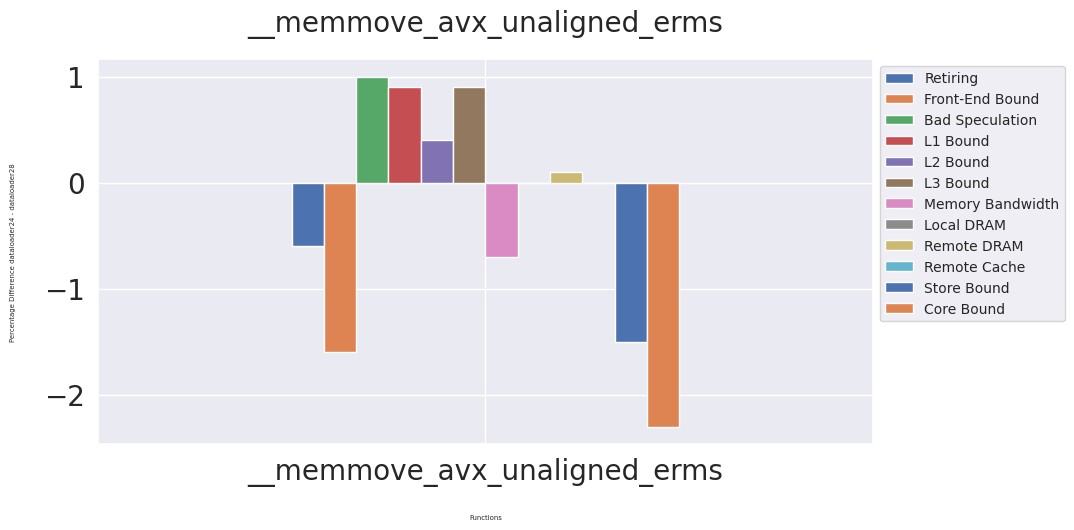

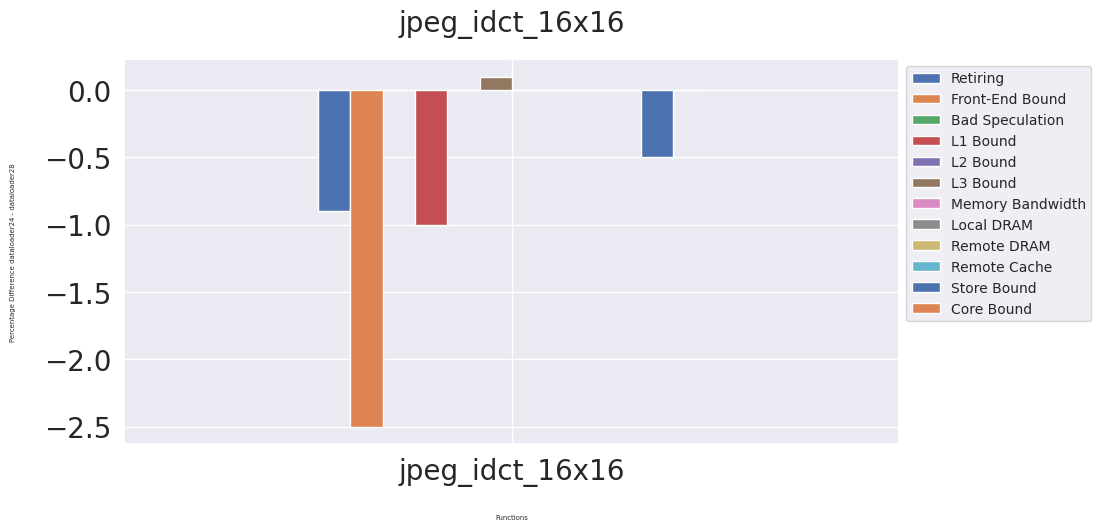

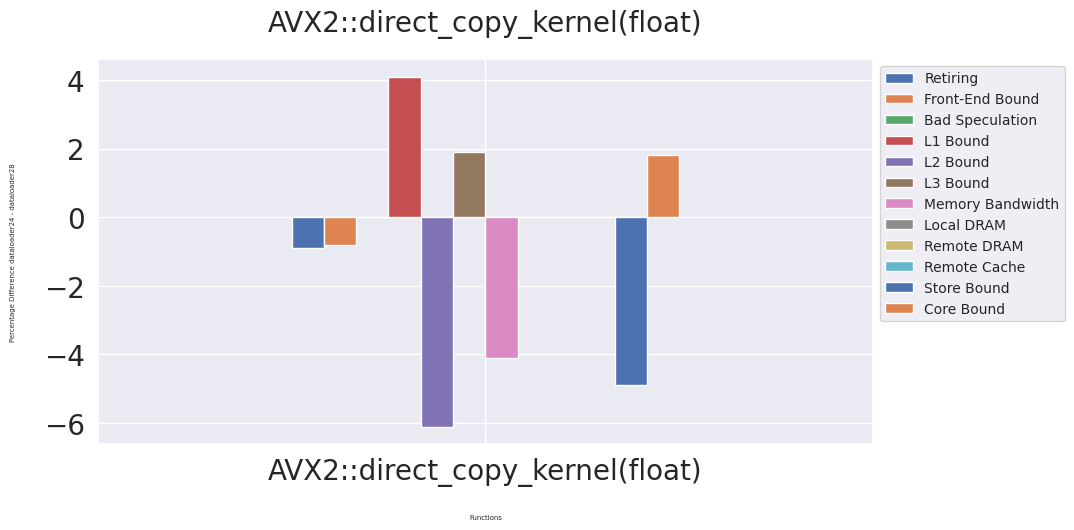

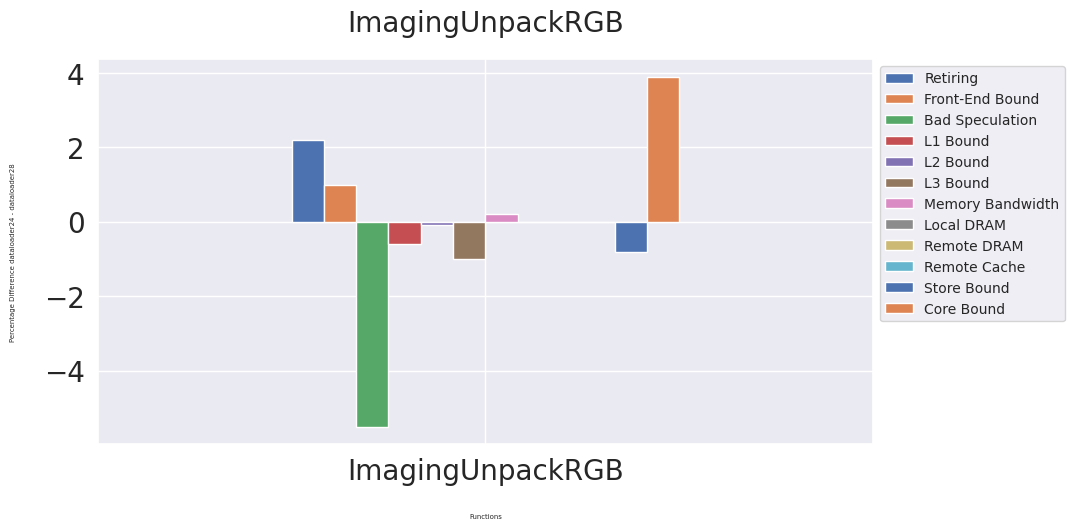

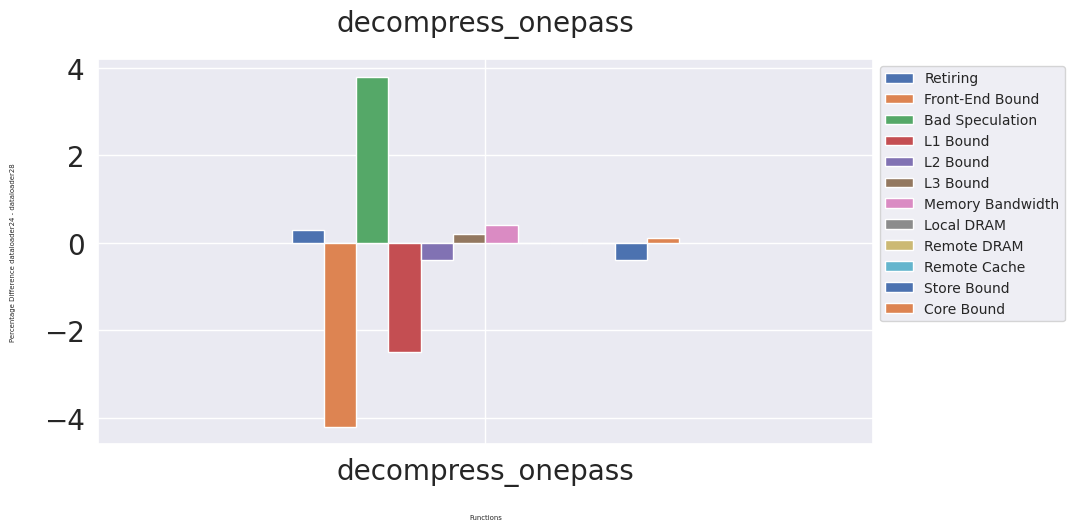

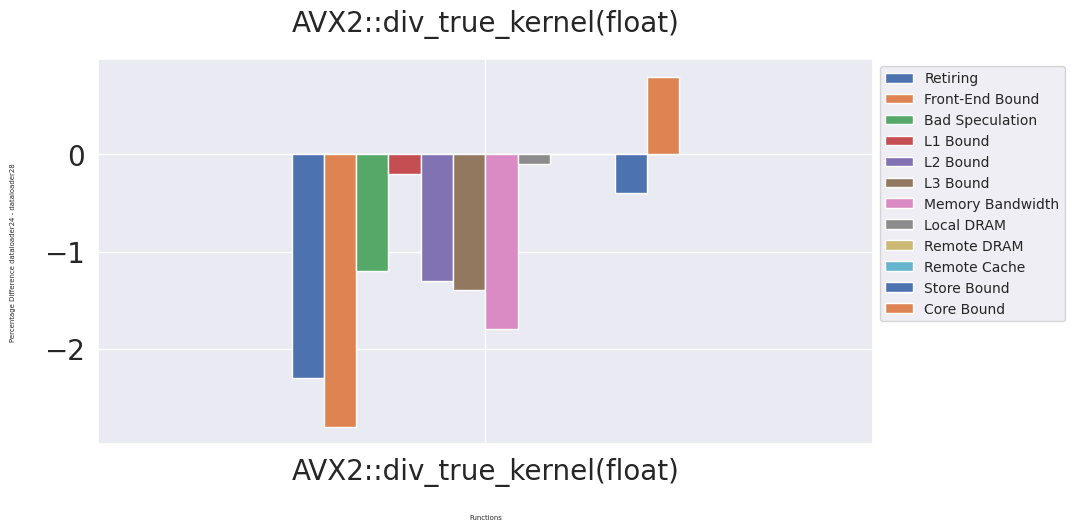

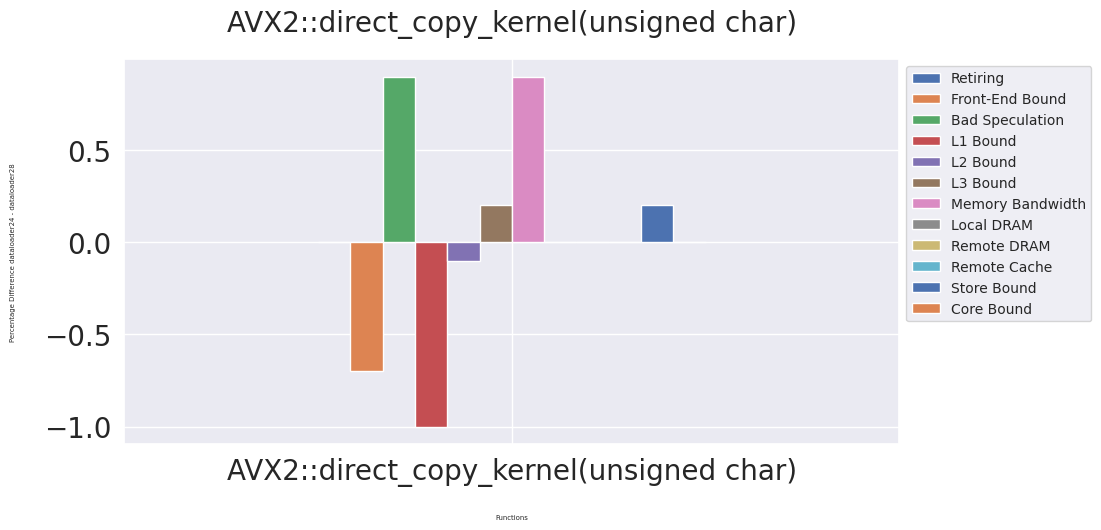

In [ ]:
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
# # increase size of axis label size
plt.rcParams['axes.labelsize'] = 20
# increase title size
plt.rcParams['axes.titlesize'] = 20
# increase space between axis label and axis
plt.rcParams['axes.labelpad'] = 20
# increase space between title and plot
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size'] = 20
# plot for each function on a subplot
for func in df3['Functions'].unique():
    df3[df3['Functions'] == func].plot(x='Functions', kind='bar', figsize=(10, 5))
    plt.xlabel('Functions')
    plt.ylabel(f'Percentage Difference {config2} - {config1}')
    # make x axis label horizontal
    plt.xticks(rotation=0)
    plt.title(func)
    # make x axis title font size smaller
    plt.rcParams['axes.labelsize'] = 5
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.show()